In [1]:
import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import euclidean
from scipy.signal import savgol_filter

from transformers import pipeline
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(".."))

from data.dataset_factory import get_dataset_generator
from preprocessing.embedding_chunks import get_ready_to_embed_chunks
from preprocessing.context_chunker import get_ready_to_embed_context_chunks
from preprocessing.mean_pool_chunks import mean_pool_chunks
from preprocessing.block_splitter import deverbose_ast
from visualizer.smoothing import smooth_embeddings, smooth_multiple_embeddings

/Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
print(os.getcwd())
gen = get_dataset_generator(
    dataset_name="codeclonedataset",
    mode="pairs",
    dataset_root="data/code-clone-dataset/dataset",
    clone_type="type-2"
)

sample = next(gen)

/Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/notebooks


In [3]:
unixcoder = "microsoft/unixcoder-base"
unixoder_pipe = pipeline("feature-extraction", model=unixcoder)

codebert = "microsoft/codebert-base"
codebert_pipe = pipeline("feature-extraction", model=codebert)

graphcodebert = "microsoft/graphcodebert-base"
graphcodebert_pipe = pipeline("feature-extraction", model=graphcodebert)

models = {
    "UniXcoder": unixoder_pipe,
    "CodeBERT": codebert_pipe,
    "GraphCodeBERT": graphcodebert_pipe
}

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1744.26it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 197/197 [00:00<00:00, 2286.69it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: microsoft/graphcodebert-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_no

In [4]:
# Helper function: embed a list of snippets and mean-pool
def embed_and_pool(snippets, model_pipe):
    """
    Embed a list of code snippets and return mean-pooled vector.
    Works even if snippets produce nested token embeddings.
    """
    if not snippets:
        return None
    
    embeddings = model_pipe(snippets)  # list of snippets
    snippet_vecs = []

    for e in embeddings:
        # Flatten one level: sometimes e is [[vec1, vec2, ...]] or [[[vec1], [vec2]]]
        flat_tokens = []
        for tok in e:
            if isinstance(tok[0], list) or isinstance(tok[0], np.ndarray):
                # tok is [ [x1,x2,...], [y1,y2,...] ]
                flat_tokens.append(np.array(tok[0]))
            else:
                flat_tokens.append(np.array(tok))
        
        # Mean pool tokens per snippet
        token_mean = np.mean(np.stack(flat_tokens, axis=0), axis=0)
        snippet_vecs.append(token_mean)
    
    # Mean pool across snippets
    mean_vec = np.mean(np.stack(snippet_vecs, axis=0), axis=0)
    return mean_vec

In [5]:
all_embeddings = []

In [6]:
for (anchor, clones, nonclones) in gen:

    anchor_line_chunks_with_ast = get_ready_to_embed_chunks(anchor)
    anchor_context_chuks_with_ast = get_ready_to_embed_context_chunks(anchor)

    anchor_line_chunks = [snippet for _, snippet, _ in anchor_line_chunks_with_ast]
    anchor_context_chunks = [snippet for _, snippet, _ in anchor_context_chuks_with_ast]

    clone = clones[0] # first clone only

    clone_line_chunks_with_ast = get_ready_to_embed_chunks(clone)
    clone_context_chuks_with_ast = get_ready_to_embed_context_chunks(clone)

    clone_line_chunks = [snippet for _, snippet, _ in clone_line_chunks_with_ast]
    clone_context_chunks = [snippet for _, snippet, _ in clone_context_chuks_with_ast]

    
    nc = nonclones[0]

    nc_line_chunks_with_ast = get_ready_to_embed_chunks(nc)
    nc_context_chuks_with_ast = get_ready_to_embed_context_chunks(nc)

    nc_line_chunks = [snippet for _, snippet, _ in nc_line_chunks_with_ast]
    nc_context_chunks = [snippet for _, snippet, _ in nc_context_chuks_with_ast]

    # Embed all models and all chunk types
    sample_embeddings = {}
    for model_name, pipe in models.items():
        sample_embeddings[model_name] = {
            "anchor": {
                "line": embed_and_pool(anchor_line_chunks, pipe),
                "context": embed_and_pool(anchor_context_chunks, pipe)
            },
            "clone": {
                "line": embed_and_pool(clone_line_chunks, pipe),
                "context": embed_and_pool(clone_context_chunks, pipe)
            },
            "nonclone": {
                "line": embed_and_pool(nc_line_chunks, pipe),
                "context": embed_and_pool(nc_context_chunks, pipe)
            }
        }
        


    # Store per sample
    all_embeddings.append(sample_embeddings)


In [7]:
print(all_embeddings)

[{'UniXcoder': {'anchor': {'line': array([-2.51386950e-01, -7.57913093e-02,  4.49927526e-01,  1.20566364e+00,
        3.39764915e-01,  1.36352451e-01, -9.19565926e-01, -1.46580479e+00,
        3.33176429e-01,  1.05023012e+00,  8.80979498e-02,  1.40228968e+00,
       -1.18454889e+00, -5.75434317e-02, -8.19188451e-01,  1.07787237e+00,
        3.94665902e-01, -1.26608752e+00, -3.49551174e-01, -5.61367969e-01,
       -1.61207396e+00,  3.99040461e+00, -3.51738383e-01,  2.15491302e-02,
       -3.29873403e-01, -5.32087497e-01,  6.04867666e-01, -1.84993216e-01,
        2.48168538e-01,  6.18232131e-01, -3.14689998e+00,  4.54015613e-01,
       -1.79658396e+00, -1.86210183e+00, -2.63998034e-01,  1.08499614e+00,
        5.56633741e-01,  1.40580995e+00, -1.77317480e-01, -7.37161954e-01,
        6.91112292e-01,  4.52191571e-01, -2.24408800e-01,  1.09730980e+00,
       -4.64700833e-01, -3.24764567e-01,  1.81535763e-01,  5.09807850e-01,
        6.61322306e-01,  9.61215523e-01,  6.07550010e-01, -4.8971

In [13]:
def plot_embedding_lines(sample_embeddings, model_name):
    """
    Plot embeddings as smoothed lines, compute cumulative L2 distances,
    and show ratio (Anchor-NonClone / Anchor-Clone) in title.
    """
    emb = sample_embeddings[model_name]

    # Prepare embeddings
    anchor_line = emb["anchor"]["line"]
    clone_line = emb["clone"]["line"]
    nonclone_line = emb["nonclone"]["line"]

    anchor_ctx = emb["anchor"]["context"]
    clone_ctx = emb["clone"]["context"]
    nonclone_ctx = emb["nonclone"]["context"]

    # Smoothing using Savitzky-Golay
    window = 101  # must be odd and <= length of vector
    poly = 3
    def smooth(vec):
        w = min(window, len(vec) - (len(vec)+1)%2)  # ensure odd and <= len
        return savgol_filter(vec, w, poly, mode='nearest')

    # Smooth embeddings
    anchor_line_s = smooth(anchor_line)
    clone_line_s = smooth(clone_line)
    nonclone_line_s = smooth(nonclone_line)

    anchor_ctx_s = smooth(anchor_ctx)
    clone_ctx_s = smooth(clone_ctx)
    nonclone_ctx_s = smooth(nonclone_ctx)

    # --- FUNCTION TO COMPUTE CUMULATIVE L2 ---
    def cumulative_l2(vec1, vec2):
        diff = vec1 - vec2
        cum_l2 = np.sqrt(np.cumsum(diff ** 2))
        final_l2 = cum_l2[-1]
        return cum_l2, final_l2

    # Compute cumulative L2 for line chunks
    _, final_l2_ac_line = cumulative_l2(anchor_line_s, clone_line_s)
    _, final_l2_anc_line = cumulative_l2(anchor_line_s, nonclone_line_s)
    ratio_line = final_l2_anc_line / final_l2_ac_line if final_l2_ac_line != 0 else np.nan

    # Compute cumulative L2 for context chunks
    _, final_l2_ac_ctx = cumulative_l2(anchor_ctx_s, clone_ctx_s)
    _, final_l2_anc_ctx = cumulative_l2(anchor_ctx_s, nonclone_ctx_s)
    ratio_ctx = final_l2_anc_ctx / final_l2_ac_ctx if final_l2_ac_ctx != 0 else np.nan

    # X-axis is embedding index
    x_line = np.arange(len(anchor_line_s))
    x_ctx = np.arange(len(anchor_ctx_s))

    # --- PLOTTING LINE CHUNKS ---
    plt.figure(figsize=(12,4))
    plt.plot(x_line, anchor_line_s, color='darkgreen', label='Anchor', linewidth=2)
    plt.plot(x_line, clone_line_s, color='lightgreen', label='Clone', linewidth=2)
    plt.plot(x_line, nonclone_line_s, color='red', label='Non-clone', linewidth=2)
    plt.title(f"{model_name} - Line Chunks\n"
              f"Final L2 Anchor-Clone: {final_l2_ac_line:.3f}, "
              f"Anchor-NonClone: {final_l2_anc_line:.3f}, "
              f"Ratio (NC/Clone): {ratio_line:.2f}")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Value")
    plt.legend()
    plt.show()

    # --- PLOTTING CONTEXT CHUNKS ---
    plt.figure(figsize=(12,4))
    plt.plot(x_ctx, anchor_ctx_s, color='darkgreen', label='Anchor', linewidth=2)
    plt.plot(x_ctx, clone_ctx_s, color='lightgreen', label='Clone', linewidth=2)
    plt.plot(x_ctx, nonclone_ctx_s, color='red', label='Non-clone', linewidth=2)
    plt.title(f"{model_name} - Context Chunks\n"
              f"Final L2 Anchor-Clone: {final_l2_ac_ctx:.3f}, "
              f"Anchor-NonClone: {final_l2_anc_ctx:.3f}, "
              f"Ratio (NC/Clone): {ratio_ctx:.2f}")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Value")
    plt.legend()
    plt.show()




Sample 1


--- Model: UniXcoder ---



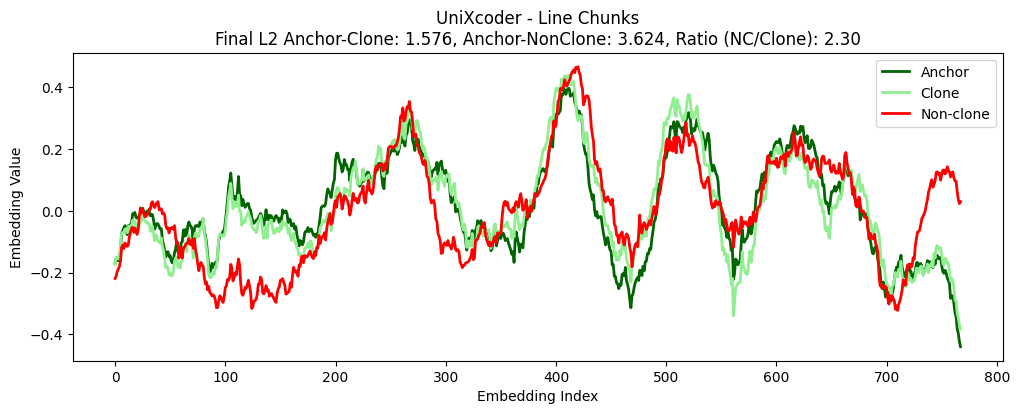

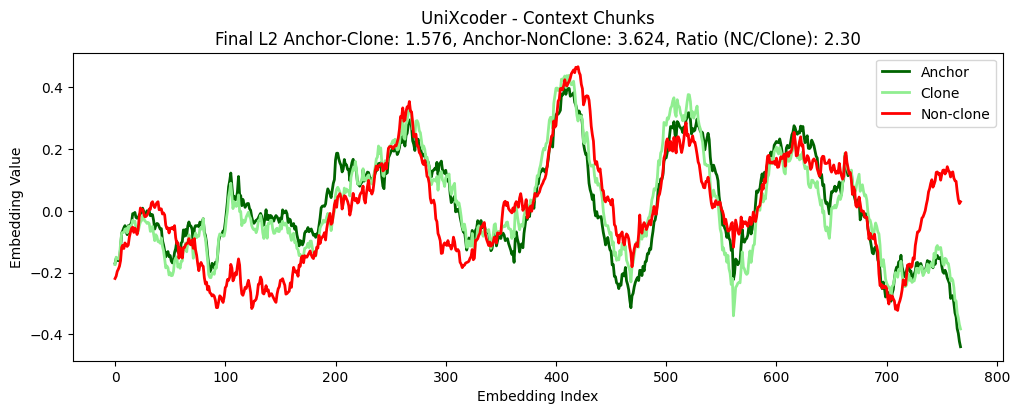


--- Model: CodeBERT ---



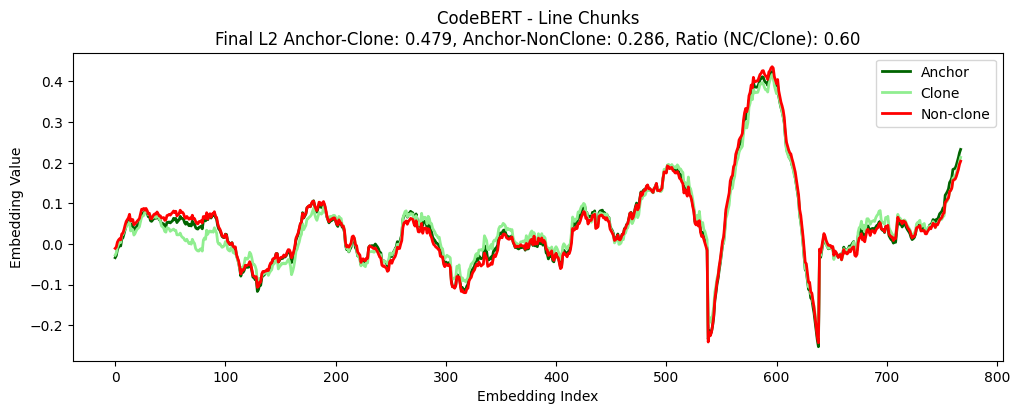

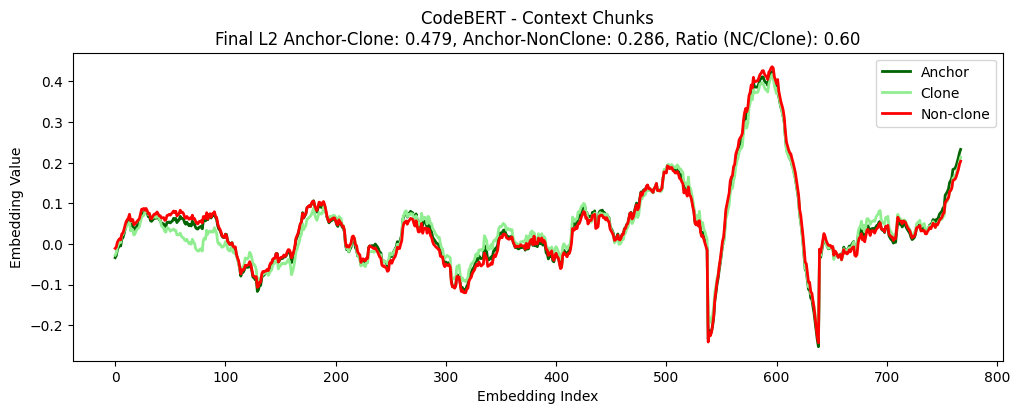


--- Model: GraphCodeBERT ---



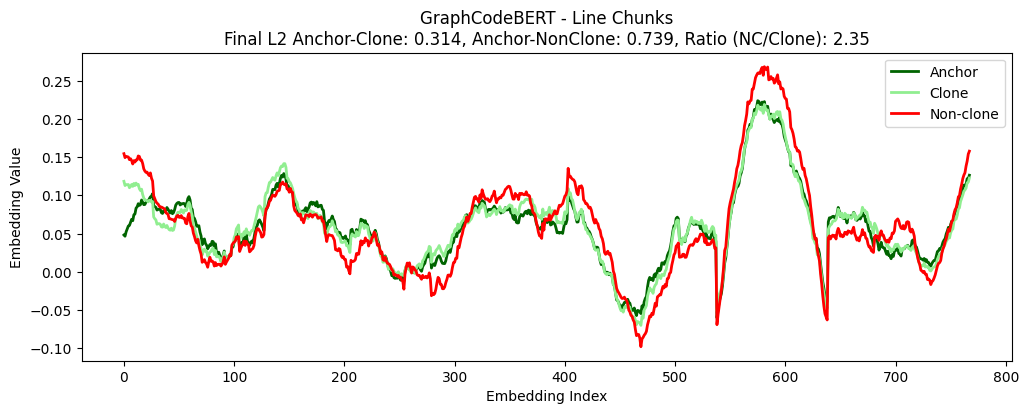

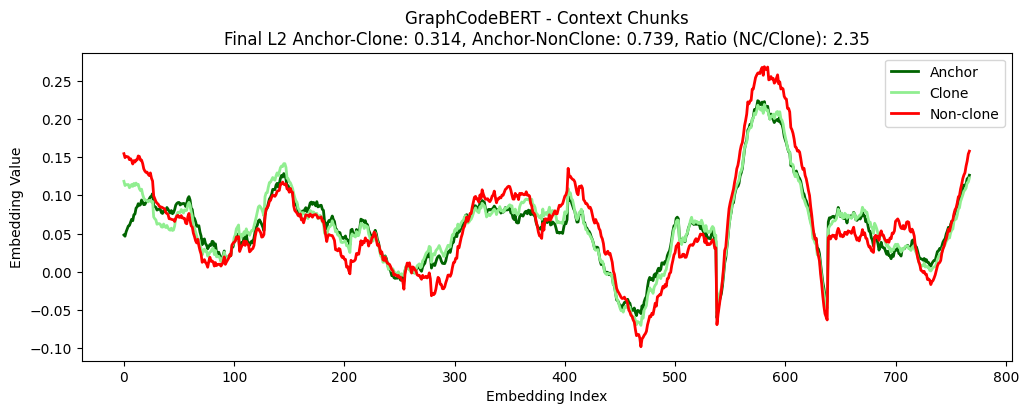



Sample 2


--- Model: UniXcoder ---



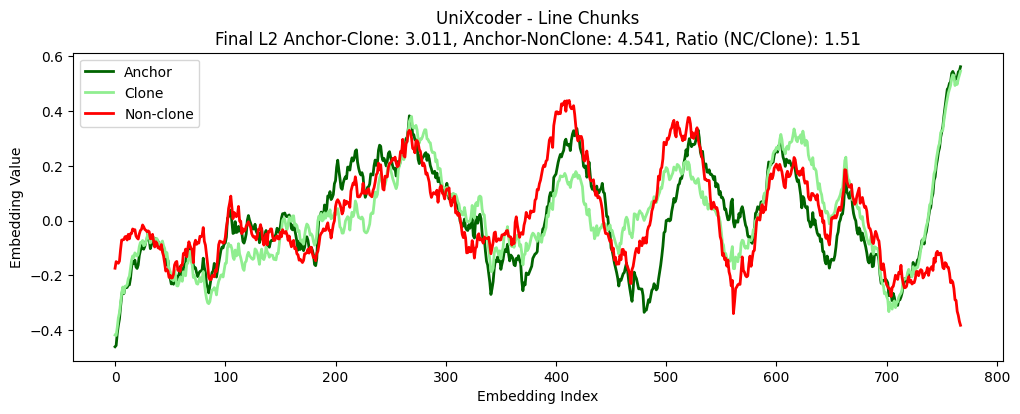

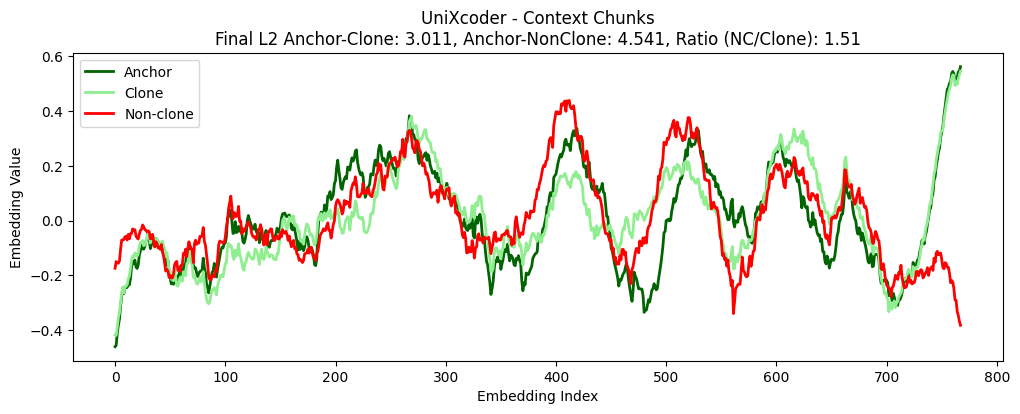


--- Model: CodeBERT ---



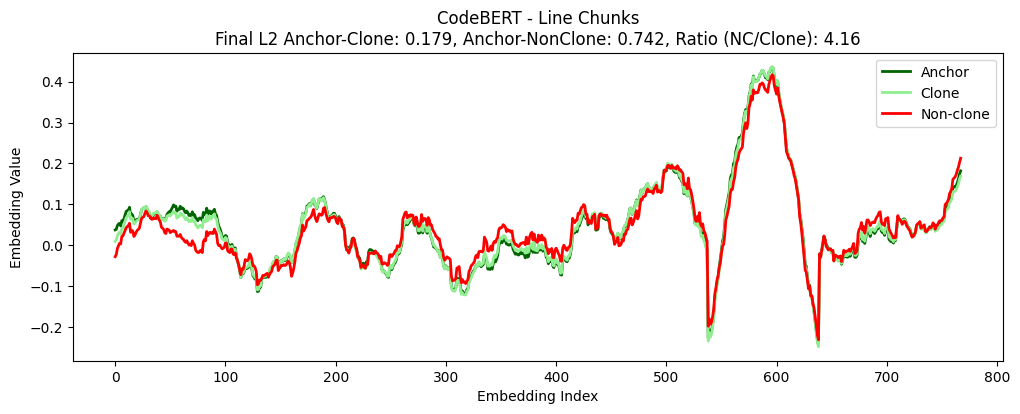

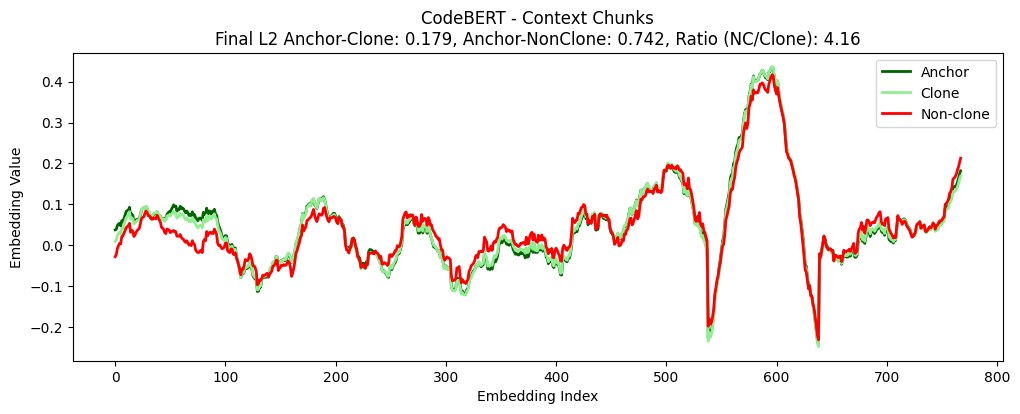


--- Model: GraphCodeBERT ---



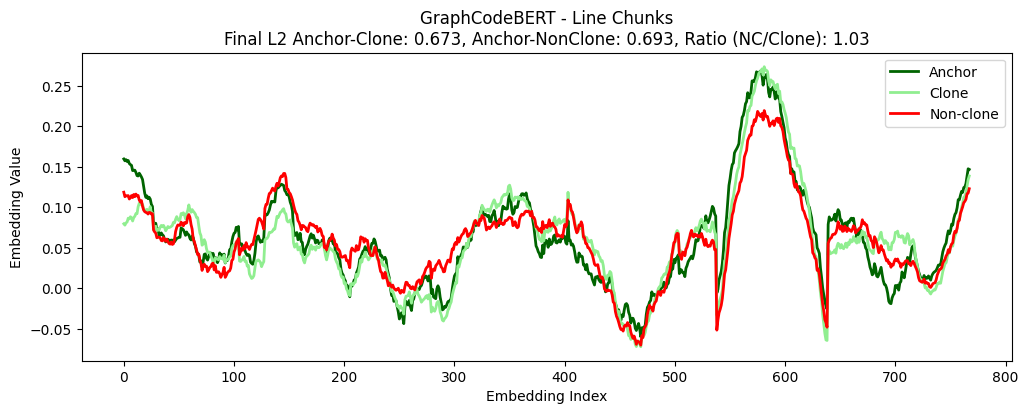

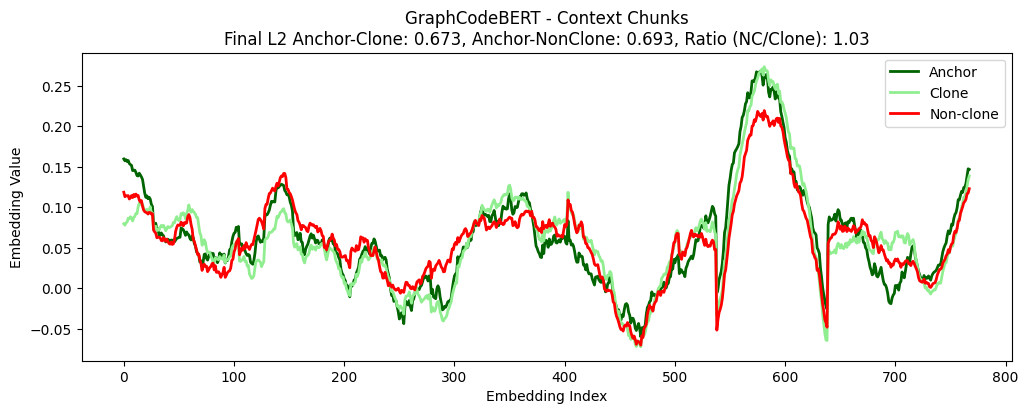



Sample 3


--- Model: UniXcoder ---



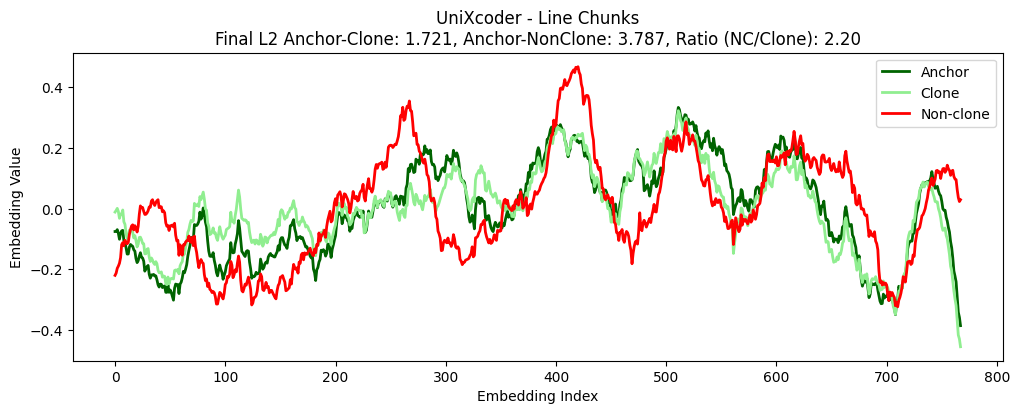

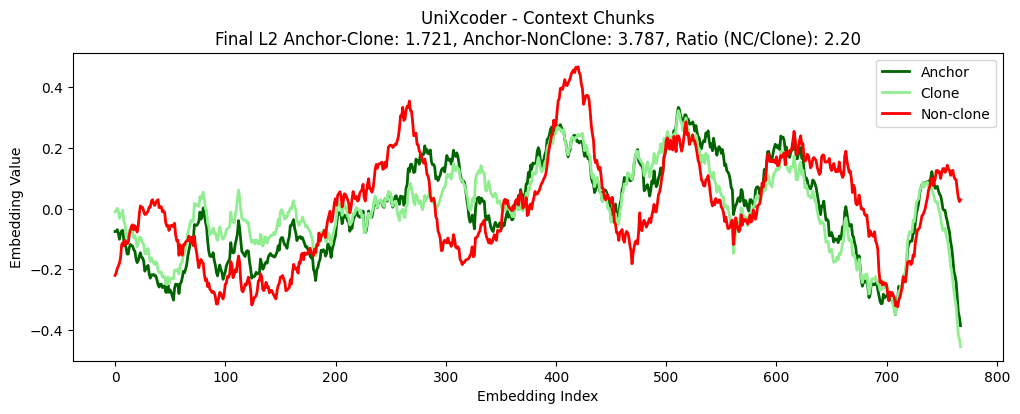


--- Model: CodeBERT ---



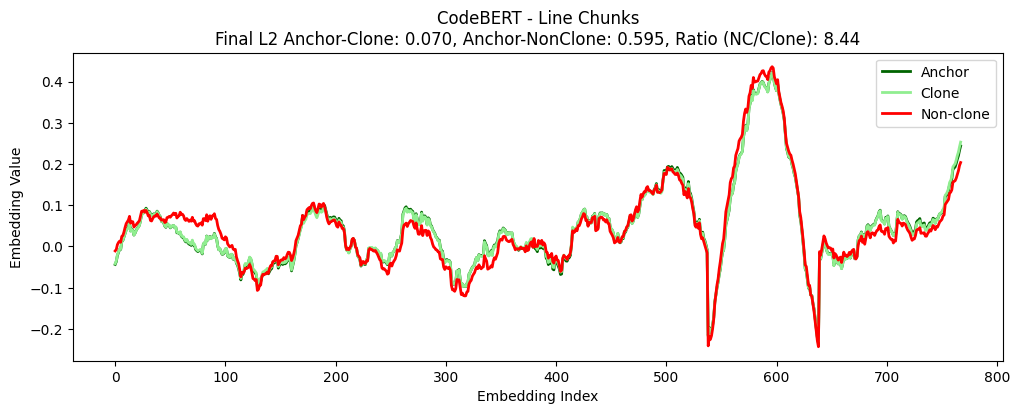

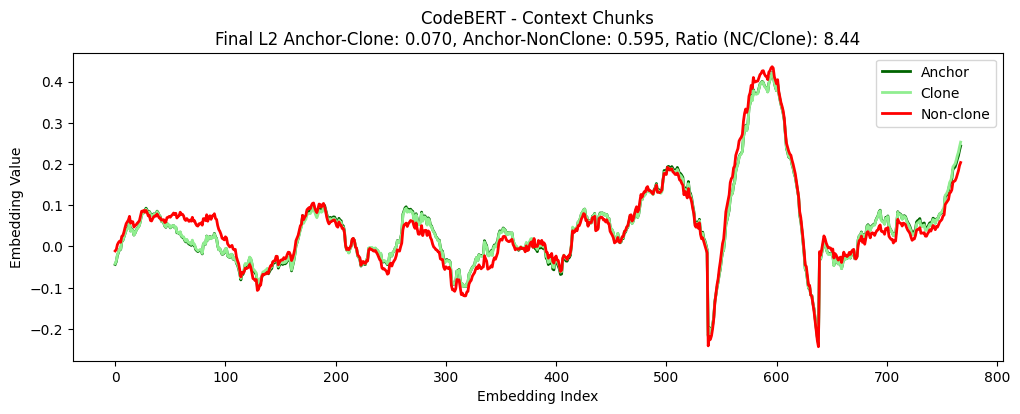


--- Model: GraphCodeBERT ---



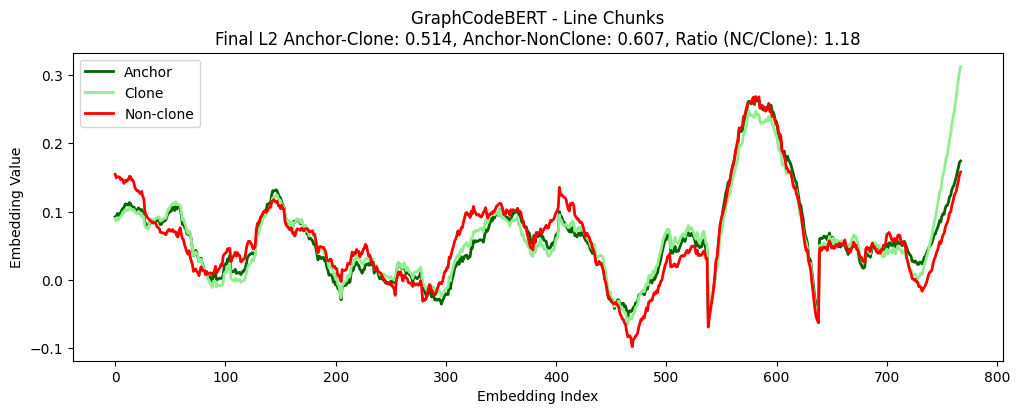

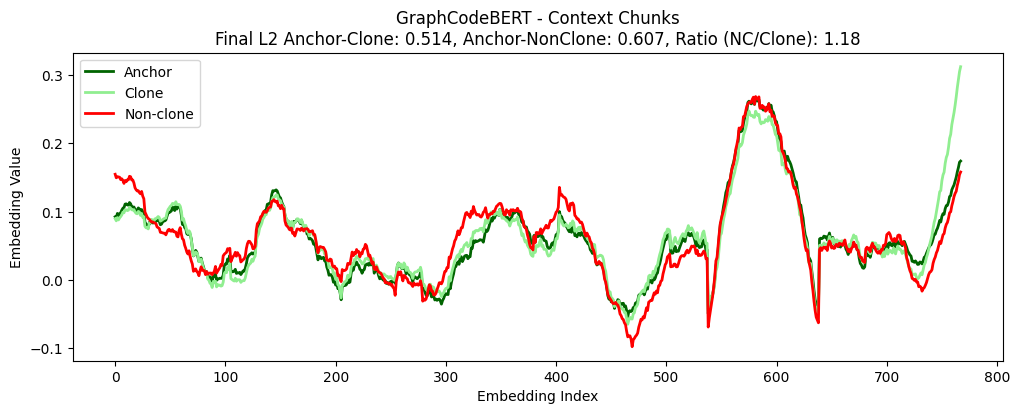



Sample 4


--- Model: UniXcoder ---



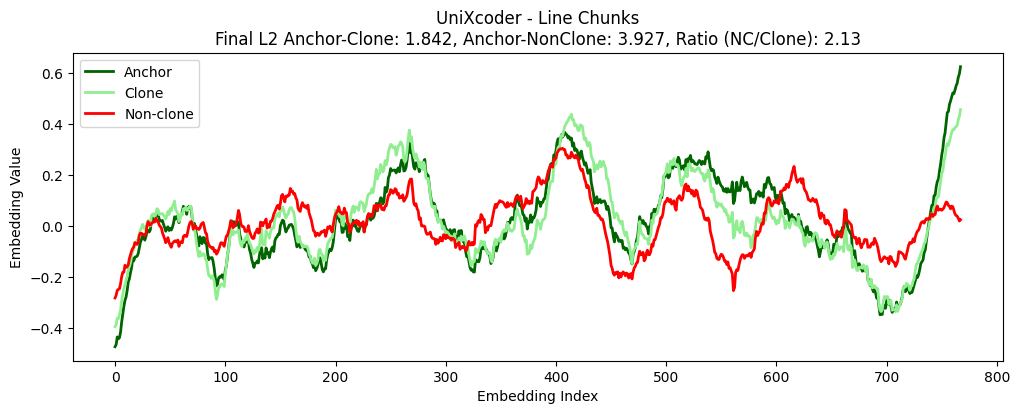

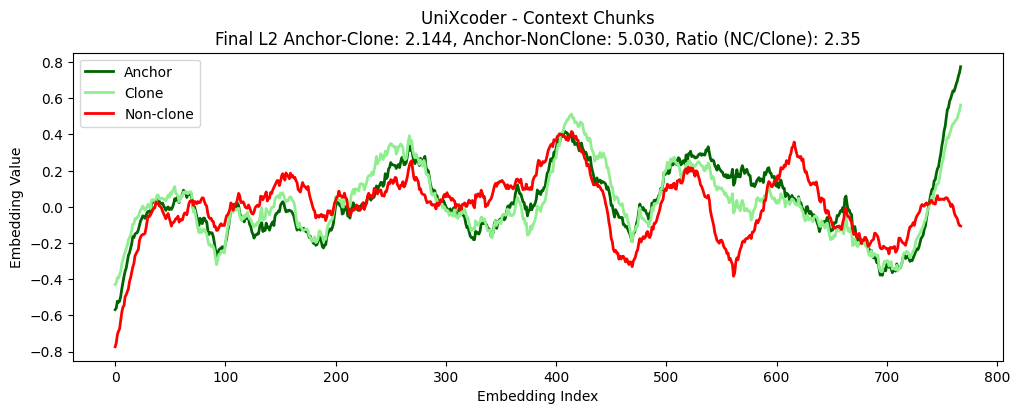


--- Model: CodeBERT ---



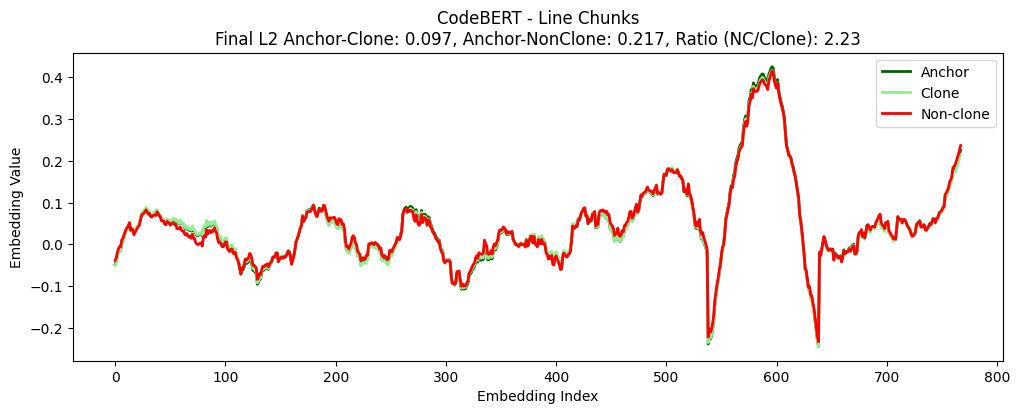

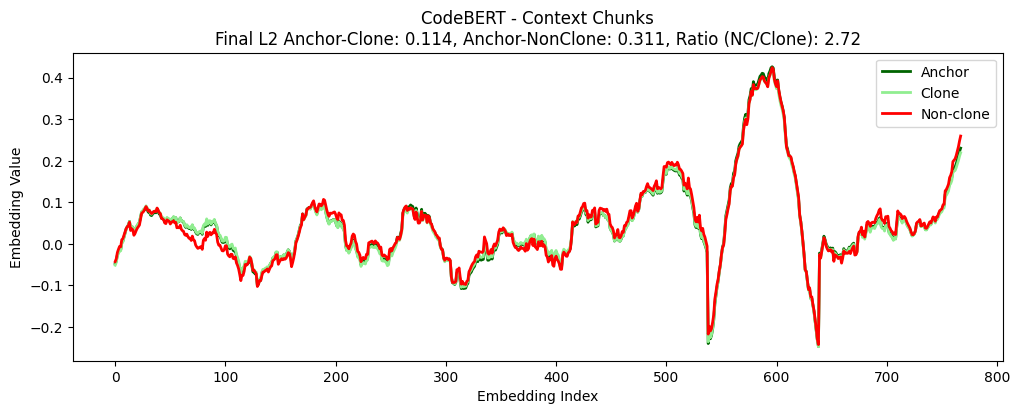


--- Model: GraphCodeBERT ---



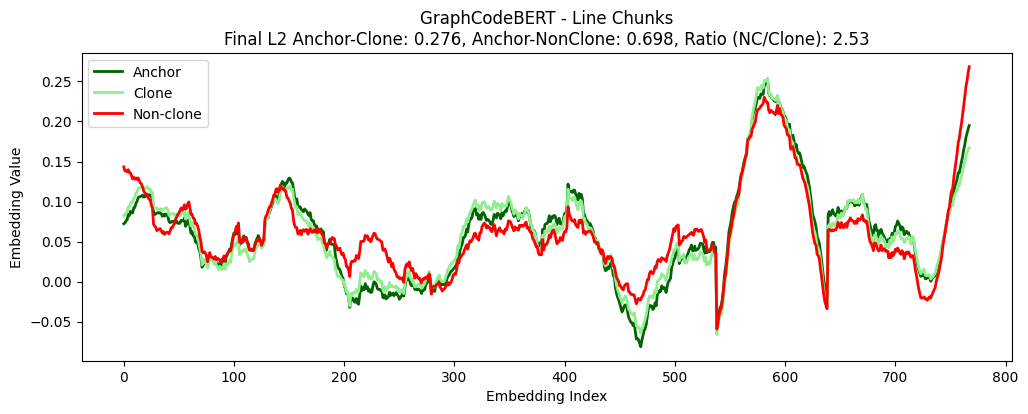

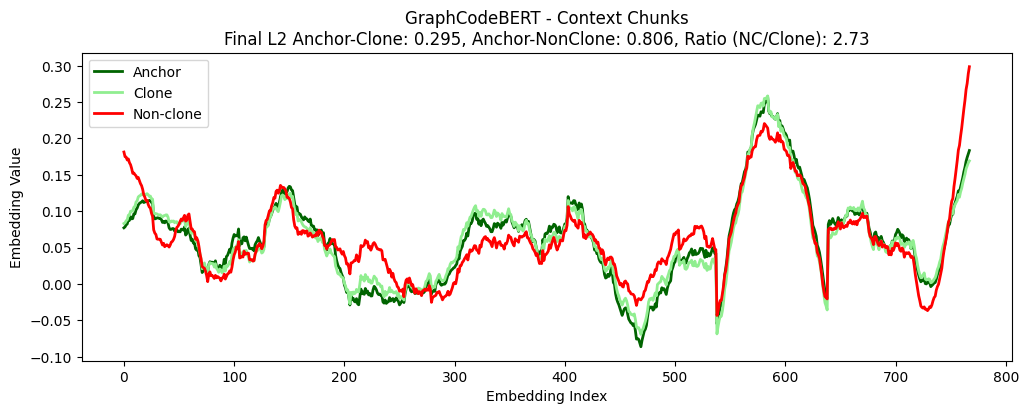



Sample 5


--- Model: UniXcoder ---



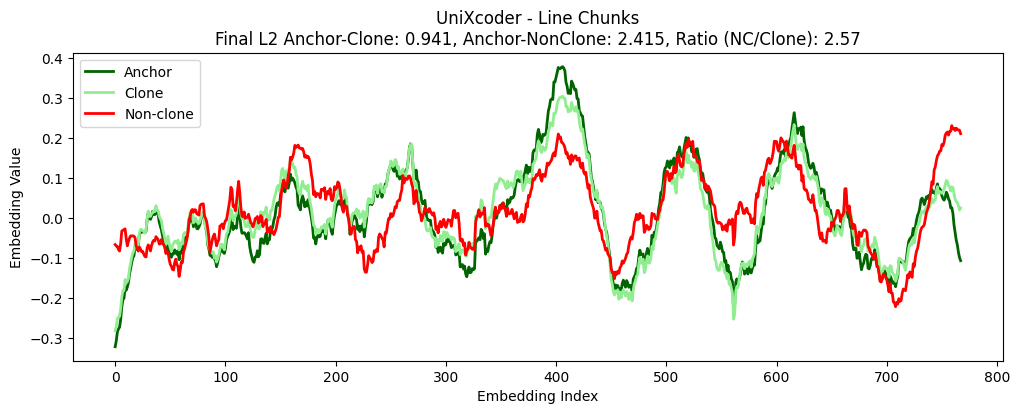

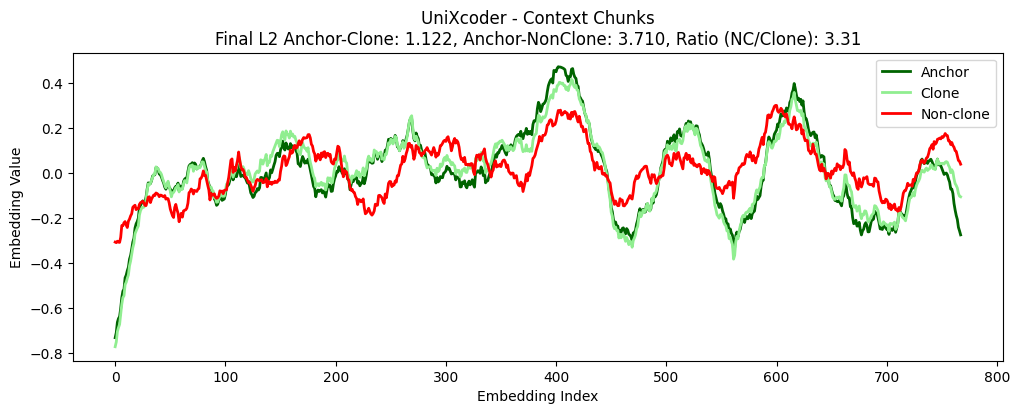


--- Model: CodeBERT ---



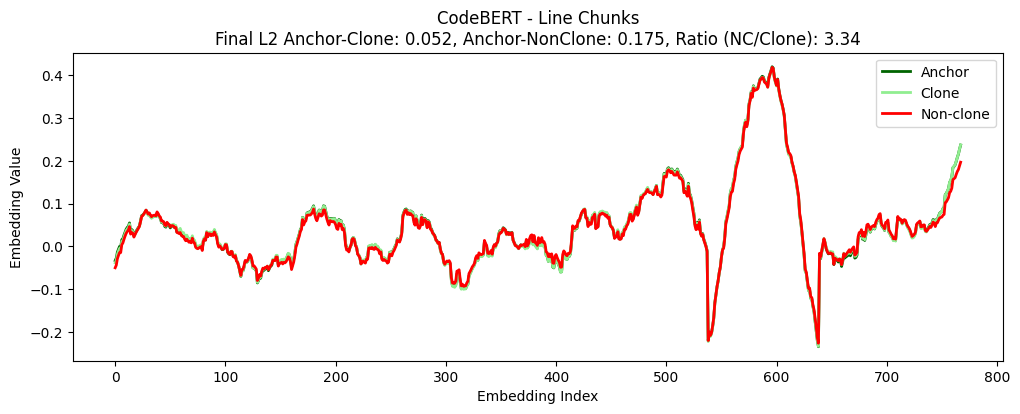

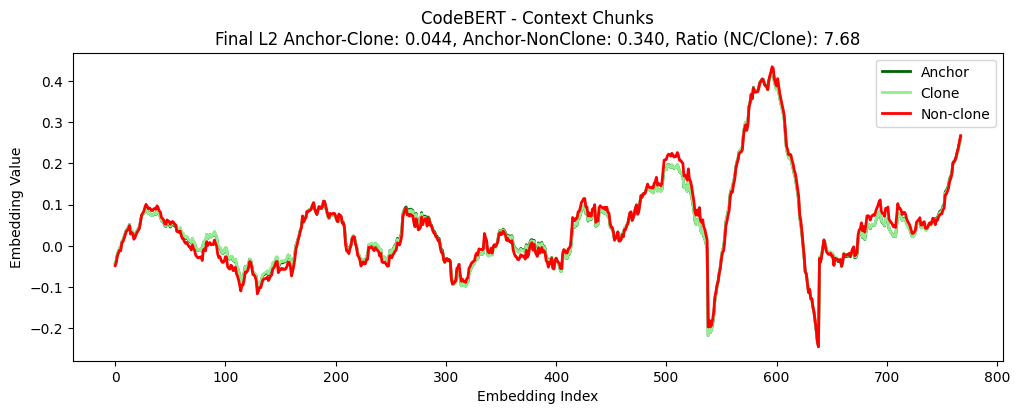


--- Model: GraphCodeBERT ---



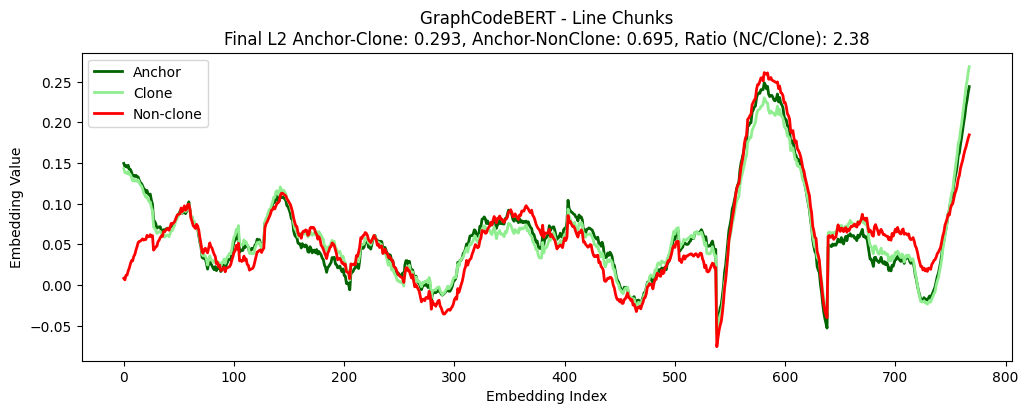

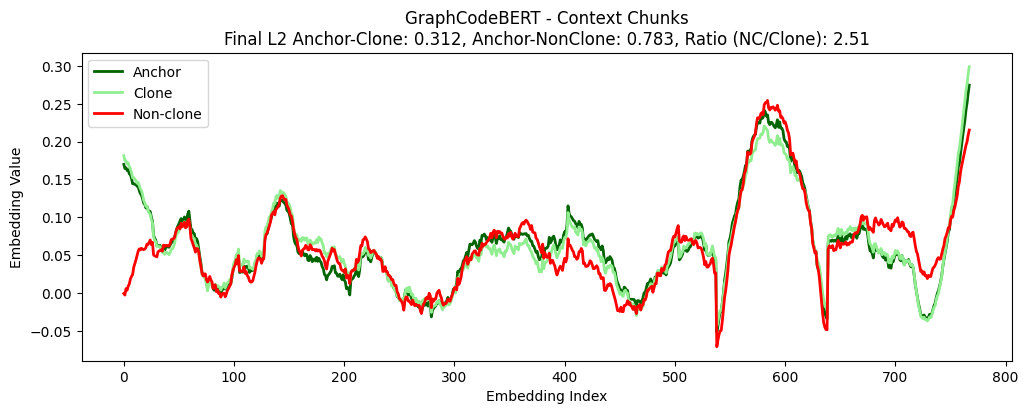



Sample 6


--- Model: UniXcoder ---



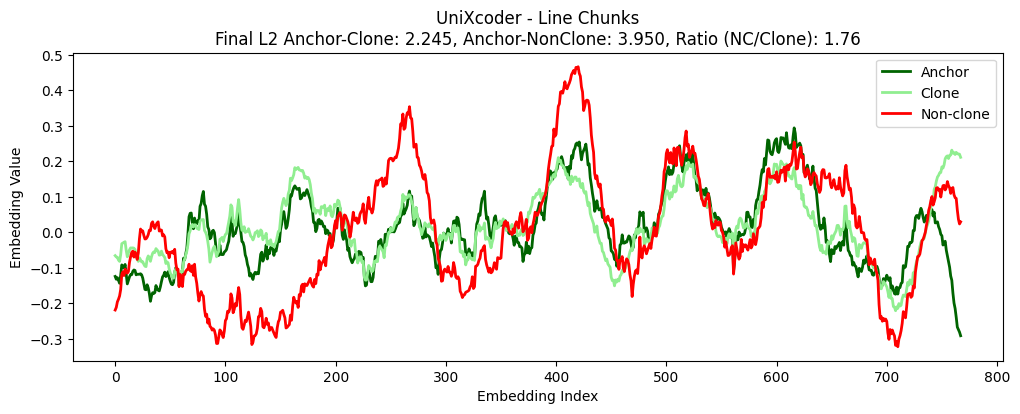

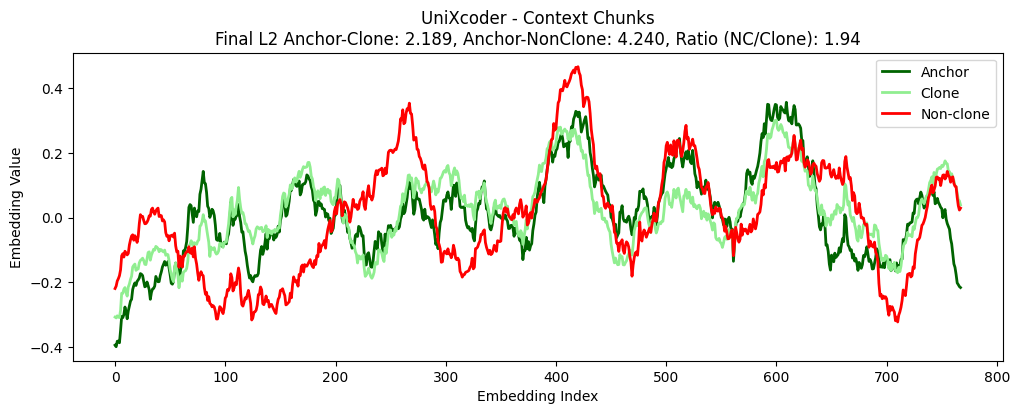


--- Model: CodeBERT ---



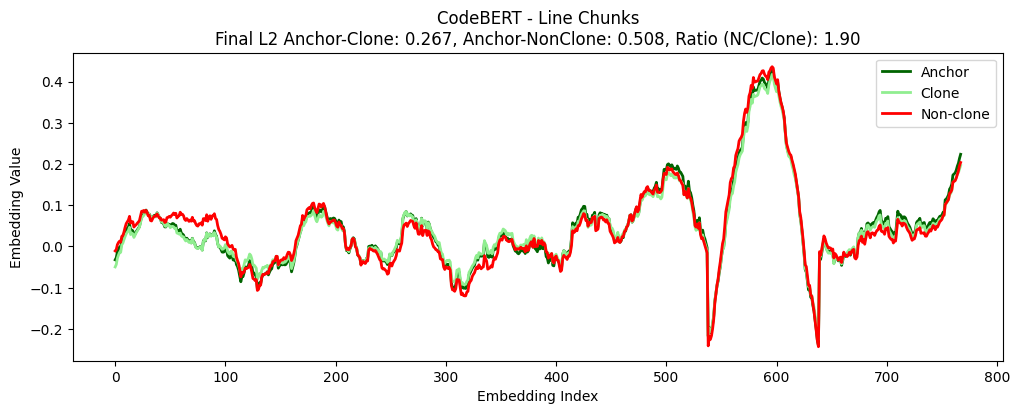

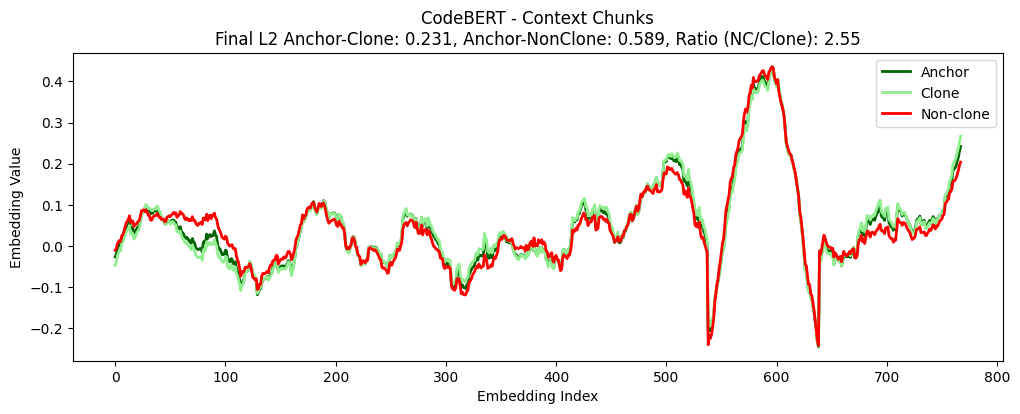


--- Model: GraphCodeBERT ---



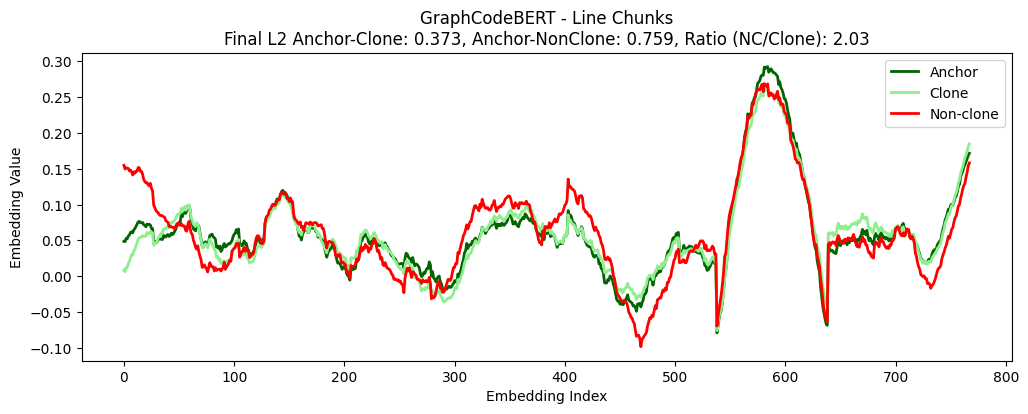

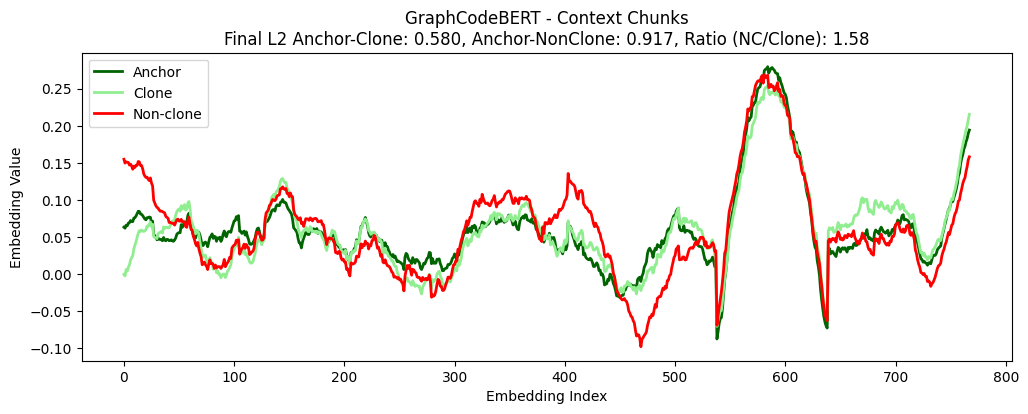



Sample 7


--- Model: UniXcoder ---



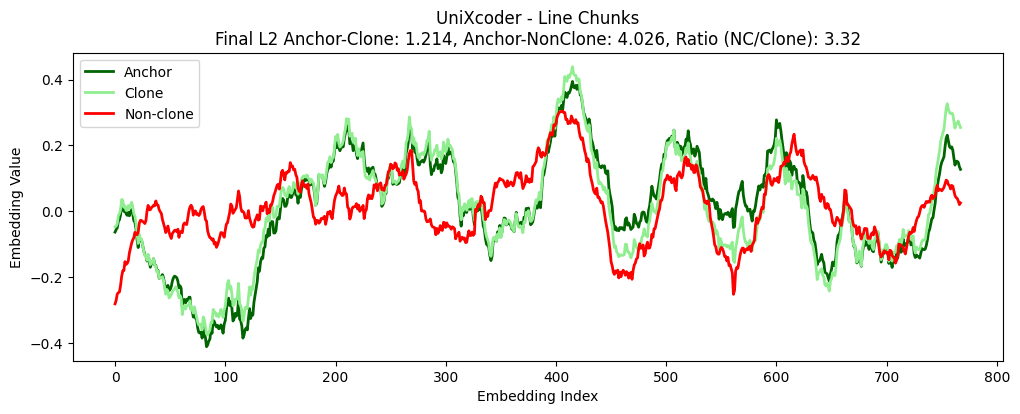

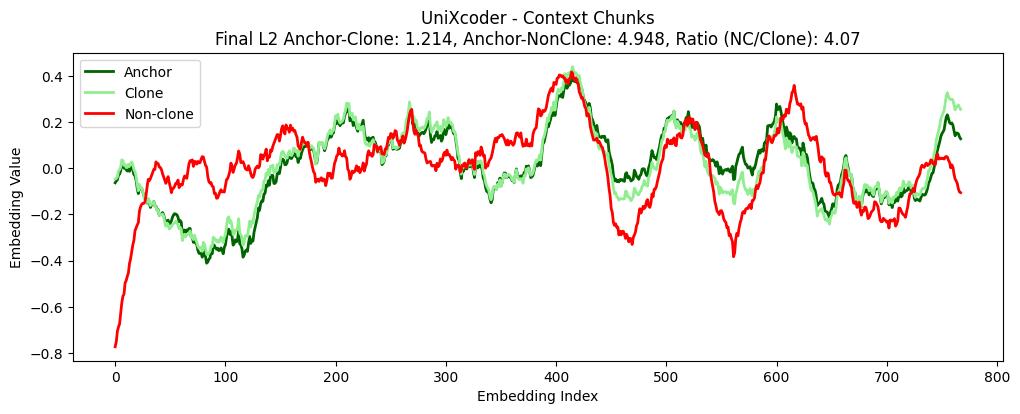


--- Model: CodeBERT ---



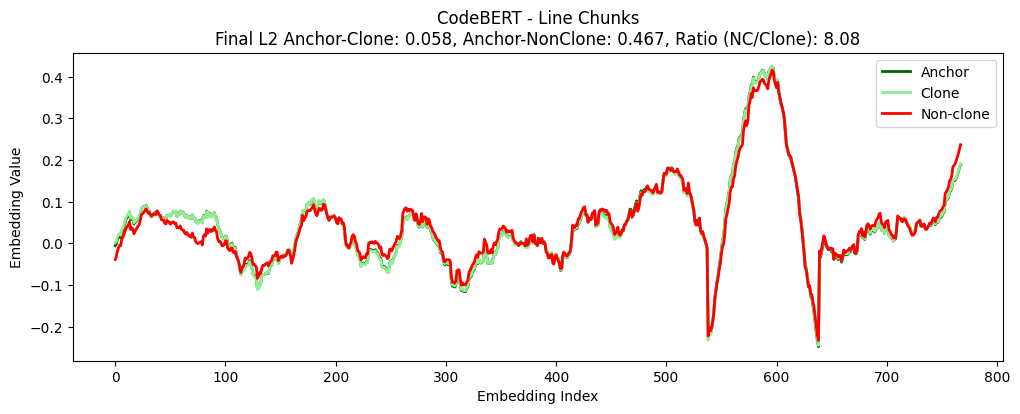

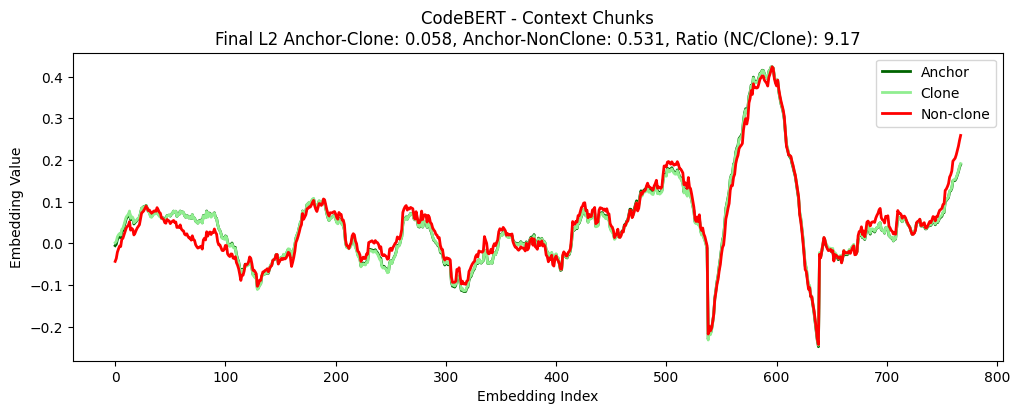


--- Model: GraphCodeBERT ---



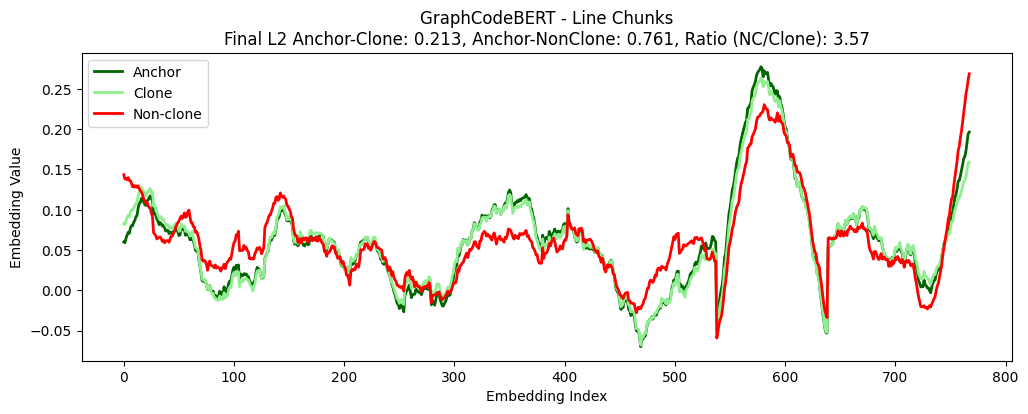

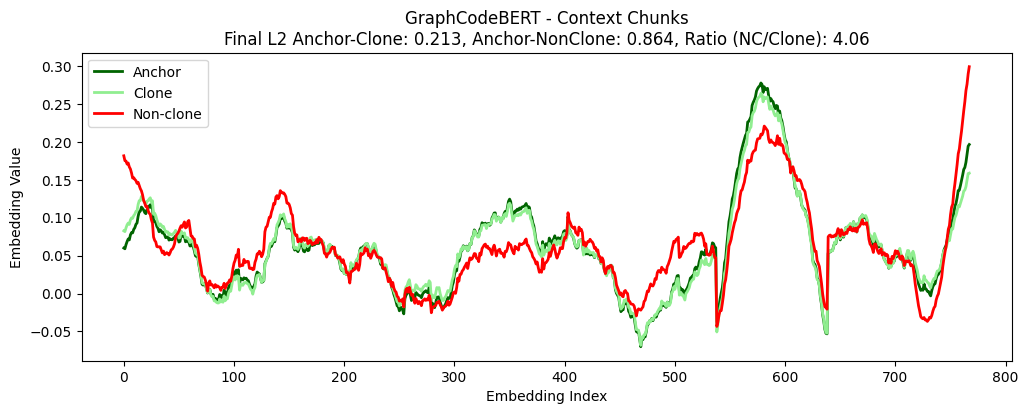



Sample 8


--- Model: UniXcoder ---



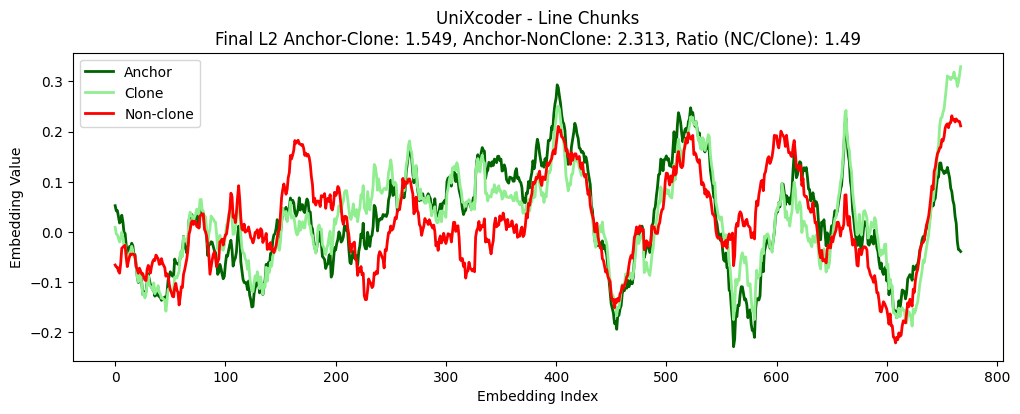

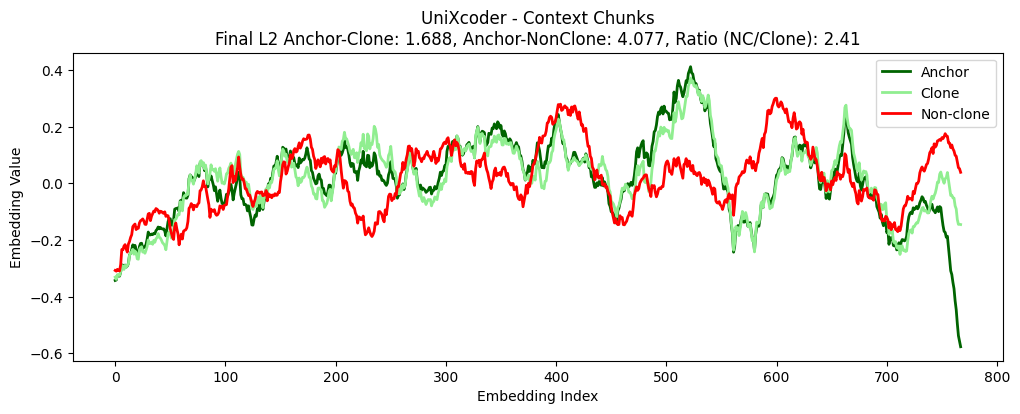


--- Model: CodeBERT ---



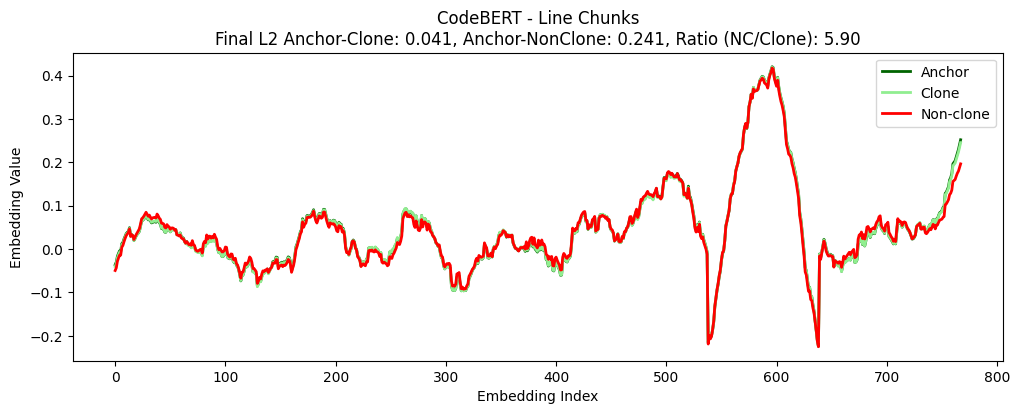

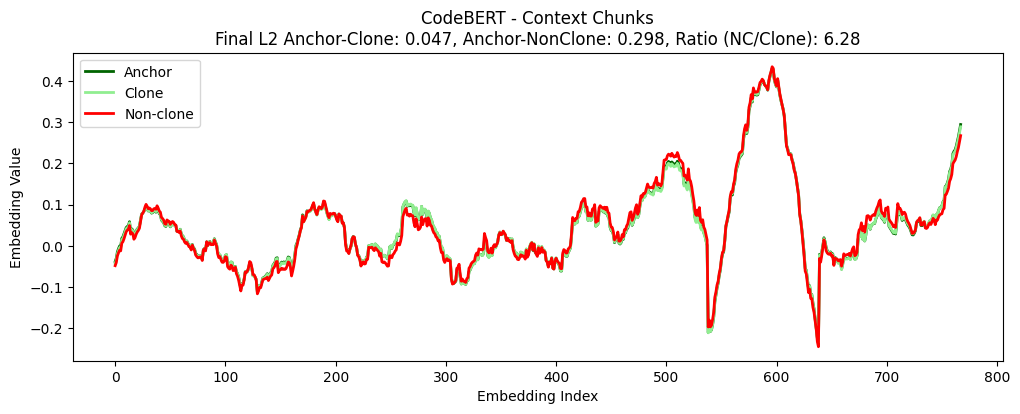


--- Model: GraphCodeBERT ---



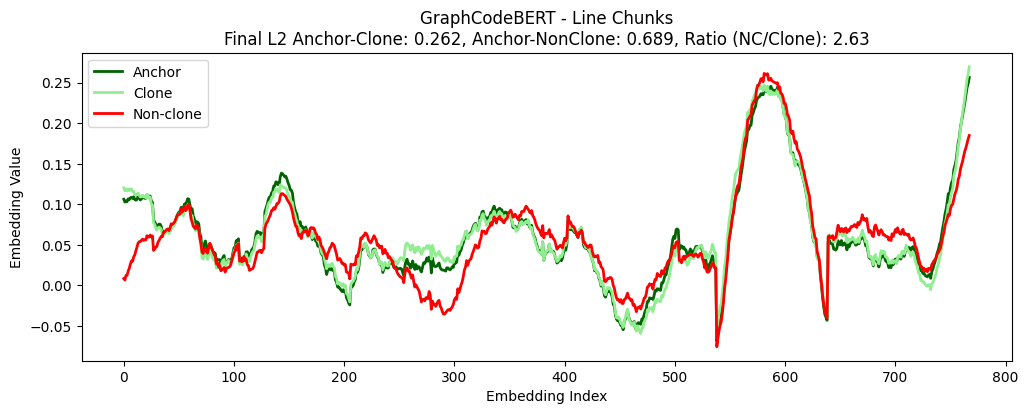

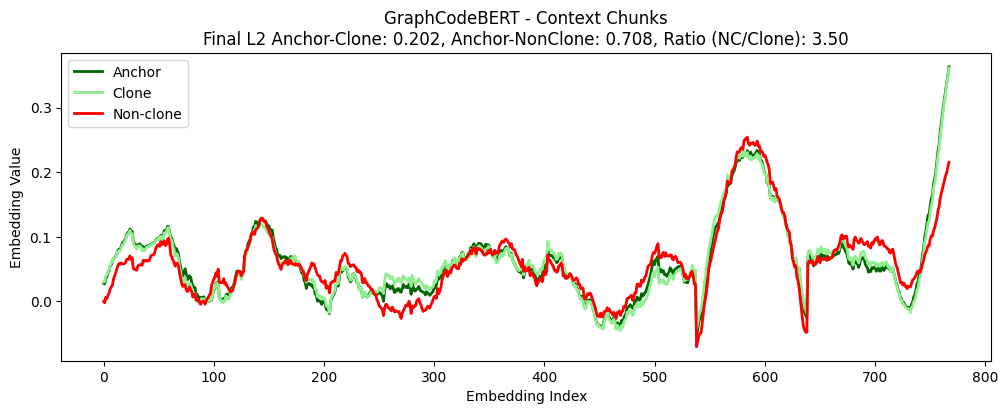



Sample 9


--- Model: UniXcoder ---



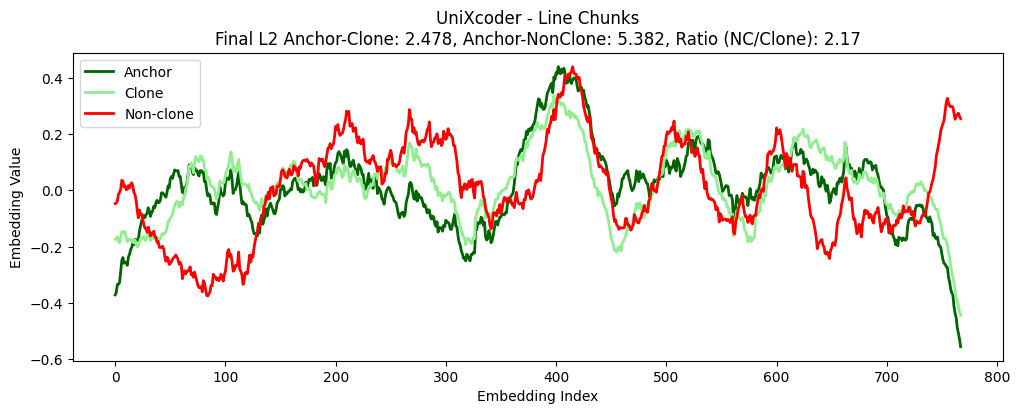

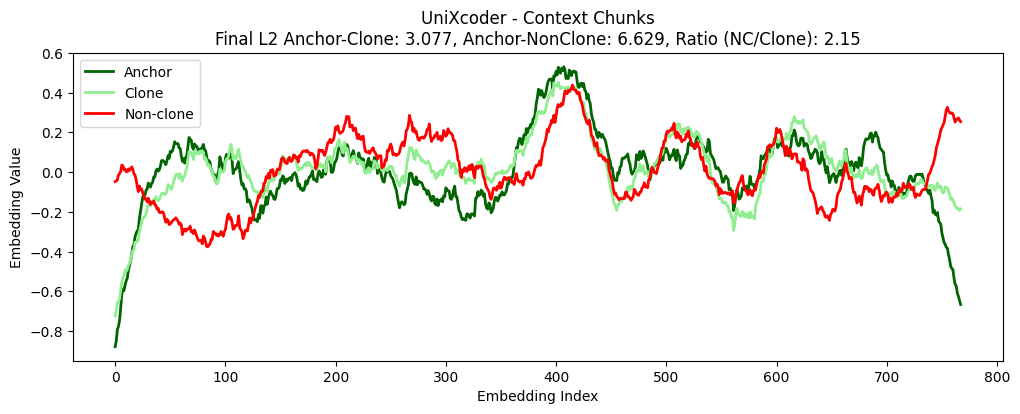


--- Model: CodeBERT ---



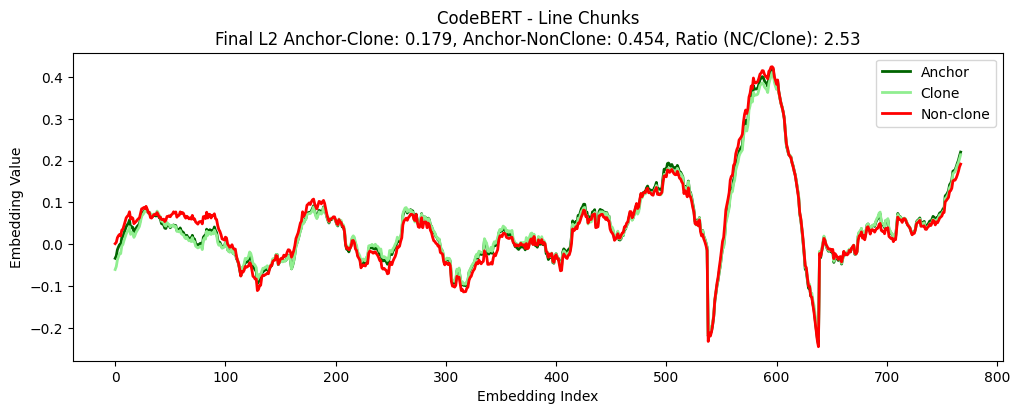

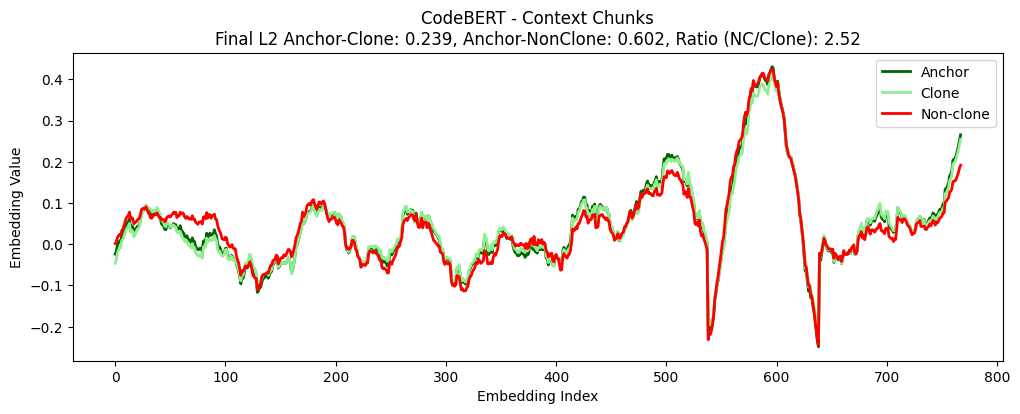


--- Model: GraphCodeBERT ---



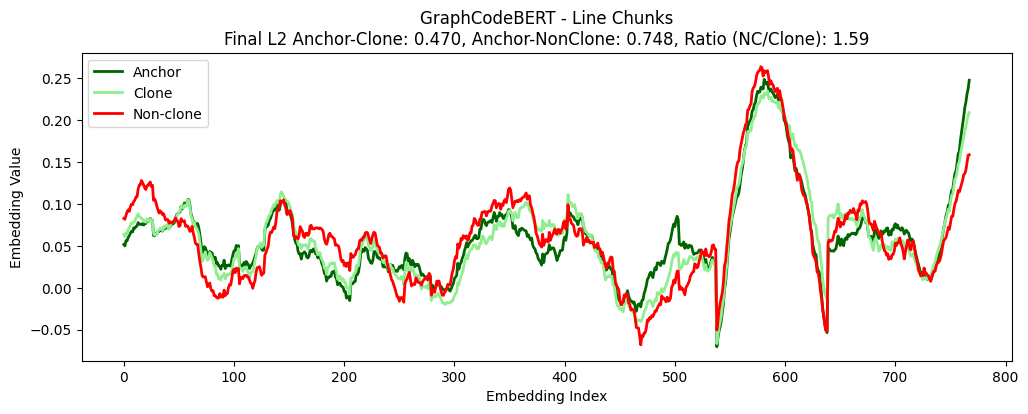

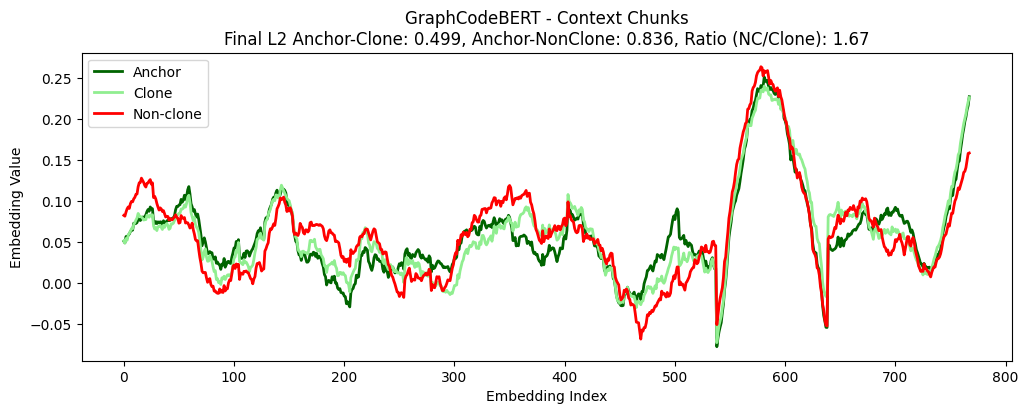

In [16]:
# Loop through all samples
for i, sample in enumerate(all_embeddings):
    print(f"\n\n{'='*50}\nSample {i+1}\n{'='*50}\n")

    for model_name in ["UniXcoder", "CodeBERT", "GraphCodeBERT"]:
        print(f"\n--- Model: {model_name} ---\n")
        plot_embedding_lines(sample, model_name)